<a href="https://colab.research.google.com/github/JonathanAMichaels/Numerai_NN/blob/main/Numerai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import copy
import torch.nn as nn
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
from scipy import stats
from scipy.io import loadmat
from IPython.display import display, clear_output

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

url = 'https://drive.google.com/uc?id=1K7CnXKoEW7sKCwb9D6TboQsVDWgVdiez'
output = 'numerai_training_validation_target_nomi.parquet'
gdown.download(url, output, quiet=False)

training_data = pd.read_parquet("/content/numerai_training_validation_target_nomi.parquet")
train = training_data[training_data.data_type=='train']
val = training_data[training_data.data_type=='validation']

target = "target_nomi" 
feature_columns = [c for c in train if c.startswith("feature")] 

# get indexes for each era
era_train = [np.where(train.era==uera)[0] for uera in train.era.unique()]
era_val = [np.where(val.era==uera)[0] for uera in val.era.unique()]

x = torch.tensor(train[feature_columns].to_numpy()).type(torch.FloatTensor).to(device)
y = torch.tensor(np.reshape(train[target].to_numpy(), (-1, 1))).type(torch.FloatTensor).to(device)
x_val = torch.tensor(val[feature_columns].to_numpy()).type(torch.FloatTensor).to(device)
y_val = val[target].to_numpy()

GPU


Downloading...
From: https://drive.google.com/uc?id=1K7CnXKoEW7sKCwb9D6TboQsVDWgVdiez
To: /content/numerai_training_validation_target_nomi.parquet
81.2MB [00:00, 137MB/s] 


In [3]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 15000, x.shape[1], 4000, 1

# Use the nn package to define our model and loss function.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.RReLU(),
    nn.Linear(H, D_out),
    nn.Sigmoid(),
)
model.to(device)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-5)

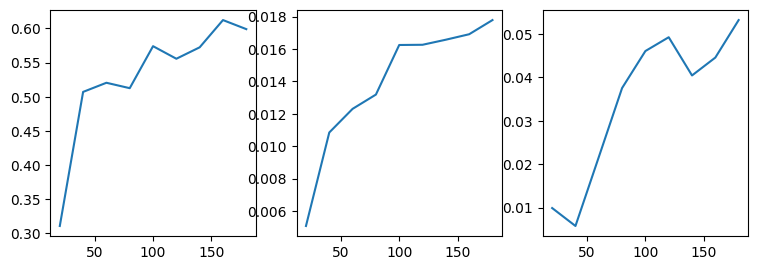

In [ ]:
fig = plt.figure(figsize=(9,3), dpi=100)
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

all_loss = []
all_sharpe = []
all_cor = []
all_traincor = []
all_t = []
best_sharpe = 0
for t in range(5000):
    batch_ind = np.random.randint(0,x.shape[0]-1,N)
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x[batch_ind,:])

    # Compute loss.
    criterion = torch.nn.BCELoss()
    loss = criterion(y_pred, y[batch_ind])
  
    [traincor, p] = stats.spearmanr(y_pred.cpu().detach().numpy(), y[batch_ind].cpu().detach().numpy())
    y_pred_val = model(x_val)
    cor = []
    temp_pred = y_pred_val.cpu().detach().numpy()
    for i in range(len(era_val)):
        [temp, p] = stats.spearmanr(y_val[era_val[i]], temp_pred[era_val[i]])
        cor.append(temp)
    sharpe = np.mean(cor) / np.std(cor)
    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_model = copy.deepcopy(model)
        best_model.to(torch.device("cpu"))
    if (t % 20 == 0) and (t > 0):
        all_sharpe.append(sharpe)
        all_cor.append(np.mean(cor))
        all_traincor.append(traincor)
        all_t.append(t)
        ax1.cla()
        ax1.plot(all_t, all_sharpe)
        ax2.cla()
        ax2.plot(all_t, all_cor)
        ax3.cla()
        ax3.plot(all_t, all_traincor)
        display(fig)
        clear_output(wait = True)
        plt.pause(0.001)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

In [1]:
print(best_sharpe)

NameError: ignored

In [ ]:
data = {}
f = h5py.File('TournamentData.mat')
for k, v in f.items():
    data[k] = np.array(v)
data = torch.from_numpy(data.get('saveInpData')).transpose(0,1).type(torch.FloatTensor)
y_pred = best_model(data)

NameError: ignored

In [ ]:
df = pandas.read_csv("/media/jonathan/Data/Numerai/numerai_tournament_data.csv")
df.head()

In [ ]:
best_model.load_state_dict(torch.load('/media/jonathan/Data/Numerai/PYTORCH2/best_model'))
y_pred = best_model(data)

In [ ]:
df2 = pandas.DataFrame()
df2['id'] = df['id']
df2['prediction_kazutsugi'] = y_pred.detach().numpy()
df2.to_csv("/media/jonathan/Data/Numerai/PYTORCH2/pytorch_test.csv", index=False)
#torch.save(best_model.state_dict(), '/media/jonathan/Data/Numerai/PYTORCH1/best_model')